# North Carolina Litigation Predictor
# Final Preprocessing and Modeling
### Contents:
<ul>
    <li> Import Libraries
    <li> Final Preprocessing / One-Hot Encoding
    <li> Model Creation
        
</ul>

What's the ultimate outcome?  Just a straight probability of being affirmed is way too high to be indicative of winning a motion.  Perhaps a percentage above or below the dummy classifier, as showing the relative over/under probability as compared to the "average." 
        


## Import Libraries & Data

In [1]:
import io
import pandas as pd
import pickle

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, plot_confusion_matrix, roc_curve, auc)
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Open the dataframe
infile = open('ProjectData/df_features.data', 'rb')
df = pickle.load(infile)
infile.close()

### Review and Clean DataFrame of Unneeded Columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 9 columns):
Opinion                 2665 non-null object
SCT                     2665 non-null int64
Year_Filed              2665 non-null int64
File_Numbers            2665 non-null object
Result                  2665 non-null int64
Case_Type               2665 non-null object
Case_Type_Confidence    2665 non-null object
Trial_Judge             2665 non-null object
County                  2665 non-null object
dtypes: int64(3), object(6)
memory usage: 187.5+ KB


In [4]:
df.drop(['Opinion', 'SCT', 'File_Numbers', 'Case_Type_Confidence', 'Year_Filed'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 4 columns):
Result         2665 non-null int64
Case_Type      2665 non-null object
Trial_Judge    2665 non-null object
County         2665 non-null object
dtypes: int64(1), object(3)
memory usage: 83.4+ KB


In [6]:
df.isna().any()

Result         False
Case_Type      False
Trial_Judge    False
County         False
dtype: bool

In [7]:
df.shape

(2665, 4)

### One-Hot Encoding and Train/Test Split

In [8]:
y = df.Result
X = df.drop(columns = ['Result'])

In [9]:
# Either/Or of the following two:
X_gd = pd.get_dummies(X)
ohe = OneHotEncoder(handle_unknown='ignore')
X_ohe = ohe.fit_transform(X)

In [10]:
ohe.get_feature_names(X.columns)
# X.columns

array(['Case_Type_car_crash', 'Case_Type_construction',
       'Case_Type_contract', 'Case_Type_corporate',
       'Case_Type_defamation', 'Case_Type_employment',
       'Case_Type_estates', 'Case_Type_family_law',
       'Case_Type_fraud_udtpa', 'Case_Type_governmental',
       'Case_Type_insurance', 'Case_Type_landlord_tenant',
       'Case_Type_med_mal', 'Case_Type_other', 'Case_Type_premises',
       'Case_Type_products', 'Case_Type_property',
       'Case_Type_workers_comp', 'Case_Type_wrongful_death',
       'Trial_Judge_abernathy g.', 'Trial_Judge_abernethy richard',
       'Trial_Judge_adams gale', 'Trial_Judge_adkins karl',
       'Trial_Judge_albright', 'Trial_Judge_albright r.',
       'Trial_Judge_albright robert', 'Trial_Judge_albright stuart',
       'Trial_Judge_albright w.', 'Trial_Judge_aldridge thomas',
       'Trial_Judge_alexander karen', 'Trial_Judge_alford benjamin',
       'Trial_Judge_allen j.', 'Trial_Judge_allen philip',
       'Trial_Judge_allen stanley', 'Tr

In [11]:
X_gd.shape, X_ohe.shape

((2665, 605), (2665, 605))

In [12]:
# View class imbalance
y.value_counts()

1    1984
0     681
Name: Result, dtype: int64

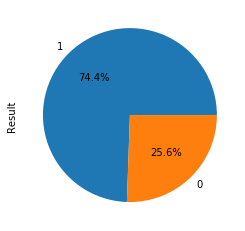

In [13]:
#Visualize class imbalance
y.value_counts().plot.pie(autopct="%.1f%%")

In [17]:
# USING X_ohe - SWITCH OUT IF DESIRED
X_train_unbalanced, X_test, y_train_unbalanced, y_test = train_test_split(X_ohe,y,random_state = 42, test_size = 0.3)

In [20]:
# sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
# X_train ,y_train = sm.fit_resample(X_train, y_train) 

indices = [i for i in range(len(X.columns))]
smnc = SMOTENC(categorical_features=indices, random_state=42, sampling_strategy='not majority')
X_train, y_train = smnc.fit_resample(X_train_unbalanced, y_train_unbalanced)

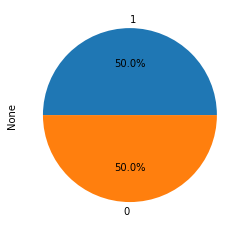

In [21]:
pd.Series(y_train).value_counts().plot.pie(autopct="%.1f%%");

In [22]:
X_train.shape, y_train.shape

((2760, 605), (2760,))

## Modeling

Some research into the best probabilistic classification models suggests that logistic regression, SVMs, and neural networks would be the best fit for the intended goal.  I will run each on the data and see which performs best. 

### Set Baseline with Dummy Classifier

In [23]:
def dummy_classifier(X_train, X_test, y_train, y_test):
    dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
    dummy_clf.fit(X_train, y_train)
    y_hat = dummy_clf.predict(X_test)
    print('Classification Report:\n', classification_report(y_test, y_hat), '\n',
          plot_confusion_matrix(dummy_clf, X_test, y_test, cmap='GnBu', values_format = '.5g'), 
          plt.show())
    return()

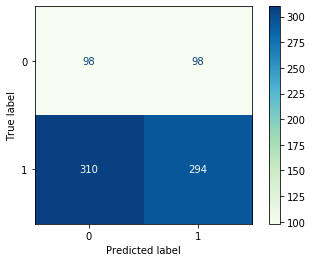

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.50      0.32       196
           1       0.75      0.49      0.59       604

    accuracy                           0.49       800
   macro avg       0.50      0.49      0.46       800
weighted avg       0.63      0.49      0.53       800
 
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f8144600ba8> None


()

In [24]:
dummy_classifier(X_train, X_test, y_train, y_test)

DUMMY CLASSIFIER sets a baseline for the next few models with a baseline accuracy of .49 and precision of 0.24/0.75 for classes 0/1 respectively.  

### Logistic Regression Model

In [28]:
def logreg_fn(X_train, X_test, y_train, y_test, params):
    logreg_clf = LogisticRegression(random_state=12)
    logreg_gs = GridSearchCV(logreg_clf, params, cv=5)
    logreg_gs.fit(X_train, y_train)
    best = logreg_gs.best_params_
    logreg_final = LogisticRegression(solver=best['solver'],
                                      penalty=best['penalty'],
                                      C=best['C'], 
                                      random_state=12)
    logreg_final.fit(X_train, y_train)
    y_hat = logreg_final.predict(X_test)
    print('Best params:',best,
          '\n\nClassification Report:\n', classification_report(y_test, y_hat), '\n',
          plot_confusion_matrix(logreg_final, X_test, y_test, cmap='GnBu', values_format = '.5g'), 
          plt.show())
    return()

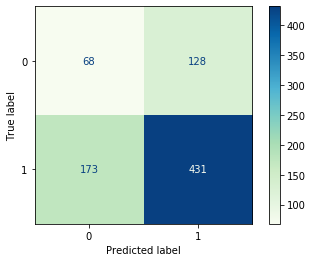

Best params: {'C': 750, 'penalty': 'none', 'solver': 'lbfgs'} 

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.35      0.31       196
           1       0.77      0.71      0.74       604

    accuracy                           0.62       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.65      0.62      0.64       800
 
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f8144c9ea90> None


()

In [29]:
parameters = {'C':[750,500,100], 
              'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'solver':['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

logreg_fn(X_train, X_test, y_train, y_test, parameters)

This model certainly improved over baseline, with accuracy increasing to .62 (a 27% increase over baseline).  However, this is still far from an ideal number. 

**Dropped Year_Filed: there's no reason this should be an input, resulted in better performance time-wise, but AUC still is dismal:**<br>
Best params: {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'} <br>
 Accuracy Score - Test:  0.6225 <br>
 Confusion Matrix: <br>
 [[ 59 134]<br>
 [168 439]] <br>
 <br>**Predicted on Trial_Judge and Case_Type:**<br>
 Best params: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'} <br>
 Accuracy Score - Test:  0.62375 <br>
 Confusion Matrix:<br>
 [[ 54 139]<br>
 [162 445]] <br>
 **Predicting on Case_Type Only:**<br>
 Best params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} <br>
 Accuracy Score - Test:  0.57375 <br>
 Confusion Matrix:<br>
 [[ 74 119]<br>
 [222 385]] <br>
 **Predicting on Trial_Judge Only:**<br>
 Best params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}  <br>
 Accuracy Score - Test:  0.56375  <br>
 Confusion Matrix: <br>
 [[ 65 128] <br>
 [221 386]]  <br>

### Neural Network

In [32]:
from numpy import loadtxt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_metrics as km

In [118]:
tf.random.set_random_seed(7)
model = Sequential()
model.add(Dense(16, input_dim=605, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [119]:
recall = km.binary_recall(label=0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall])

In [120]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Train on 2208 samples, validate on 552 samples
Epoch 1/100
2208/2208 [==============================] - 1s 384us/step - loss: 0.6877 - acc: 0.5756 - recall: 0.8036 - val_loss: 0.7761 - val_acc: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
2208/2208 [==============================] - 0s 61us/step - loss: 0.6702 - acc: 0.6236 - recall: 0.9978 - val_loss: 0.8810 - val_acc: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
2208/2208 [==============================] - 0s 59us/step - loss: 0.6637 - acc: 0.6250 - recall: 1.0000 - val_loss: 0.9116 - val_acc: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
2208/2208 [==============================] - 0s 58us/step - loss: 0.6548 - acc: 0.6250 - recall: 1.0000 - val_loss: 0.9383 - val_acc: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
2208/2208 [==============================] - 0s 59us/step - loss: 0.6478 - acc: 0.6250 - recall: 1.0000 - val_loss: 0.9356 - val_acc: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/100
2208/2208 [===================

2208/2208 [==============================] - 0s 60us/step - loss: 0.1843 - acc: 0.9343 - recall: 0.9420 - val_loss: 0.1367 - val_acc: 0.9565 - val_recall: 0.0000e+00
Epoch 47/100
2208/2208 [==============================] - 0s 55us/step - loss: 0.1954 - acc: 0.9235 - recall: 0.9457 - val_loss: 0.1559 - val_acc: 0.9384 - val_recall: 0.0000e+00
Epoch 48/100
2208/2208 [==============================] - 0s 55us/step - loss: 0.1876 - acc: 0.9425 - recall: 0.9478 - val_loss: 0.1448 - val_acc: 0.9620 - val_recall: 0.0000e+00
Epoch 49/100
2208/2208 [==============================] - 0s 54us/step - loss: 0.1710 - acc: 0.9357 - recall: 0.9420 - val_loss: 0.1395 - val_acc: 0.9674 - val_recall: 0.0000e+00
Epoch 50/100
2208/2208 [==============================] - 0s 55us/step - loss: 0.1744 - acc: 0.9393 - recall: 0.9449 - val_loss: 0.1443 - val_acc: 0.9583 - val_recall: 0.0000e+00
Epoch 51/100
2208/2208 [==============================] - 0s 55us/step - loss: 0.1685 - acc: 0.9398 - recall: 0.9522 -

Epoch 92/100
2208/2208 [==============================] - 0s 58us/step - loss: 0.1265 - acc: 0.9529 - recall: 0.9580 - val_loss: 0.1031 - val_acc: 0.9746 - val_recall: 0.0000e+00
Epoch 93/100
2208/2208 [==============================] - 0s 55us/step - loss: 0.1314 - acc: 0.9470 - recall: 0.9514 - val_loss: 0.0905 - val_acc: 0.9837 - val_recall: 0.0000e+00
Epoch 94/100
2208/2208 [==============================] - 0s 56us/step - loss: 0.1228 - acc: 0.9511 - recall: 0.9486 - val_loss: 0.0951 - val_acc: 0.9801 - val_recall: 0.0000e+00
Epoch 95/100
2208/2208 [==============================] - 0s 54us/step - loss: 0.1222 - acc: 0.9588 - recall: 0.9623 - val_loss: 0.0758 - val_acc: 0.9819 - val_recall: 0.0000e+00
Epoch 96/100
2208/2208 [==============================] - 0s 54us/step - loss: 0.1237 - acc: 0.9475 - recall: 0.9464 - val_loss: 0.1287 - val_acc: 0.9620 - val_recall: 0.0000e+00
Epoch 97/100
2208/2208 [==============================] - 0s 56us/step - loss: 0.1086 - acc: 0.9620 - rec

In [121]:
results = model.evaluate(X_test, y_test, batch_size=10)
print('Loss: ', (results[0]),
      '\nAccuracy: ',(results[1]),
      '\nRecall: ',(results[2]))

800/800 [==============================] - 0s 188us/step
Loss:  2.6436448619075237 
Accuracy:  0.6862500000745058 
Recall:  0.8476821190649534


dict_keys(['val_loss', 'val_acc', 'val_recall', 'loss', 'acc', 'recall'])


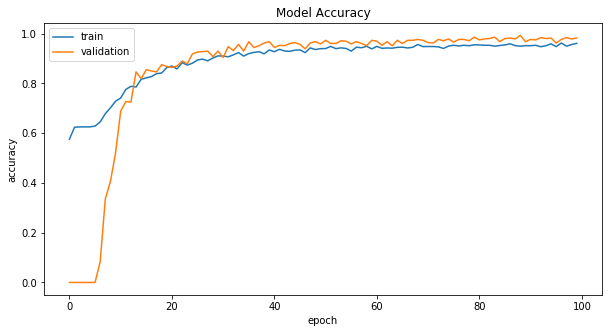

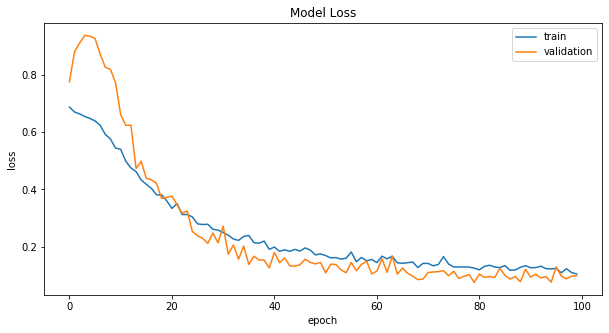

In [122]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='middle right')
plt.show()
# "Loss"
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='middle right')
plt.show()

**Results on Test Set -- last at the bottom **

3 Dense Layers (16/8/1), 100 epochs, 0.2 validation split, batch size 10<br>
Loss:  2.7501846364699305 <br>
Accuracy:  0.6687500029802322 <br>
Recall:  0.8162251654277773<br>
On the loss plot, the loss on the training data remains fairly constant, while the validation loss increases, 


3 Dense Layers (16/8/1) with dropout(0.5) after 2nd Dense, 100 epochs, 0.2 validation split, batch size 20, Changed to unbalanced data: <br>
Loss:  3.7459801264107226 <br>
Accuracy:  0.6387500042095781 <br>
Recall:  0.761589403847419<br>
On the loss plot, both training and validation dropped, but validation climbed thereafter, train continued to decline. 

Above, but add second Dropout after activation layer, change both Dropouts to 0.2:<br>
Loss:  2.2827060595154762 <br>
Accuracy:  0.6775000037625432 <br>
Recall:  0.824503311121771<br>
Loss plot shows initial cross (1st or 2nd epoch) but then smoothly divergent curves. <br>

Above, but change batch size to 50:
Loss:  2.543306863121688 
Accuracy:  0.6875000027939677 
Recall:  0.8427152316485571
Loss plot shows to distinct straight-ish lines, with validation slowly increasing but train staying constant. <br>

Above, but change batch size to 32: 
Loss:  3.0654561286384707 
Accuracy:  0.6887500001117587 
Recall:  0.8493377482037521
Loss plot still very disparate. 

<br>
RETURN to balanced data since both classes matter, increase both dropouts to 0.3, 16/8/1, batch size 32, 100 epochs:<br>**
Loss:  1.8901734507875516 
Accuracy:  0.6712500041350722 
Recall:  0.8261589402605698
Loss plot conjoins! Training/validation accuracy maxes out around 0.9, though test accuracy hasn't really changed.  RE-RAN with 200 epochs, loss begins to diverge at 120; trimmed a little to the final neural net model: 

**--------------------------------------------------------------------------------<br>
RETURN to balanced data since both classes matter, added another layer, increase all dropouts to 0.3, 16/8/8/1, batch size 32, 100 epochs:<br>**
Loss:  2.6436448619075237 
Accuracy:  0.6862500000745058 
Recall:  0.8476821190649534

In [125]:
model.predict(X_test).round(3)

array([[0.832],
       [0.996],
       [1.   ],
       [1.   ],
       [0.999],
       [1.   ],
       [1.   ],
       [1.   ],
       [0.   ],
       [0.845],
       [0.926],
       [1.   ],
       [0.975],
       [0.001],
       [1.   ],
       [0.204],
       [1.   ],
       [0.999],
       [1.   ],
       [1.   ],
       [0.   ],
       [1.   ],
       [0.991],
       [0.153],
       [1.   ],
       [0.994],
       [0.804],
       [1.   ],
       [0.   ],
       [1.   ],
       [1.   ],
       [0.999],
       [1.   ],
       [0.767],
       [0.999],
       [0.995],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [0.95 ],
       [0.95 ],
       [1.   ],
       [1.   ],
       [1.   ],
       [0.018],
       [1.   ],
       [1.   ],
       [1.   ],
       [0.993],
       [0.99 ],
       [1.   ],
       [0.   ],
       [0.999],
       [1.   ],
       [0.996],
       [1.   ],
       [0.996],
       [0.227],
       [0.909],
       [1.   ],
       [1.   ],
       [

In [126]:
j=model.predict_proba(X_test).round(3)

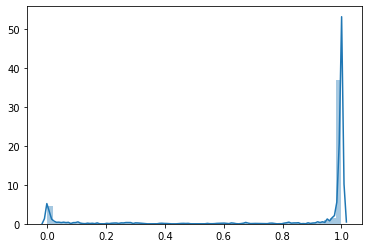

In [127]:
import seaborn as sns
sns.distplot(j)






# create pipeline
# create dashboard